In [1]:
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import datetime
import keras_metrics as km

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

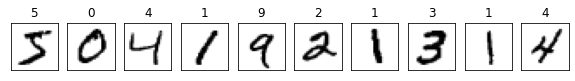

In [3]:
fig, ax = plt.subplots(1, 10, figsize=(10,10))
for i in range(0, 10):
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
    ax[i].set_title(y_train[i])
    ax[i].imshow(x_train[i], cmap=plt.cm.binary)

In [4]:
x_train = np.expand_dims(x_train, axis=-1).astype('float32')
x_test = np.expand_dims(x_test, axis=-1).astype('float32')

In [5]:
x_train /= 255
x_test /= 255

In [6]:
print('Data shape', x_train.shape)
print('Number of training samples:', x_train.shape[0])
print('Number of testing samples:', x_test.shape[0])

Data shape (60000, 28, 28, 1)
Number of training samples: 60000
Number of testing samples: 10000


In [7]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]
num_features = x_train.shape[1] + x_train.shape[2]

print('Number of classes: ', num_classes)

Number of classes:  10


In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation='relu', kernel_initializer='he_uniform', input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_initializer='he_uniform'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          3

In [10]:
log_path = 'logs/'
keyname = 'mnist'
cur_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log_dir = log_path + "fit/" + keyname + '_' + cur_date 
tensorboard_callback = TensorBoard(log_dir=tb_log_dir, histogram_freq=1)
model_checkpoint = ModelCheckpoint('model_'+keyname+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=6)
csv_logger = CSVLogger(log_path + keyname + '_' + cur_date + '.log', separator=',', append=False)

In [11]:
batch_size = 32
epochs = 100
val_split = 0.3

history = model.fit(x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[model_checkpoint,early_stopping,csv_logger,tensorboard_callback],
    validation_split=val_split)

Epoch 1/100
   1/1313 [..............................] - ETA: 0s - loss: 3.4809 - accuracy: 0.0000e+00WARNING:tensorflow:From e:\miniconda\envs\tensorflow383\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1313/1313 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.8987
Epoch 00001: loss improved from inf to 0.32226, saving model to model_mnist.hdf5
1313/1313 [==============================] - 7s 6ms/step - loss: 0.3223 - accuracy: 0.8987 - val_loss: 0.0703 - val_accuracy: 0.9788
Epoch 2/100
1304/1313 [============================>.] - ETA: 0s - loss: 0.1100 - accuracy: 0.9684
Epoch 00002: loss improved from 0.32226 to 0.10980, saving model to model_mnist.hdf5
1313/1313 [==============================] - 7s 5ms/step - loss: 0.1098 - accuracy: 0.9685 - val_loss: 0.0521 - val_accuracy

In [12]:
score = model.evaluate(x_test, y_test)
print("Test loss: ", score[0])
print("Test accuracy: ",score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0263 - accuracy: 0.9934
Test loss:  0.026308776810765266
Test accuracy:  0.993399977684021


In [17]:
np.argmax(model.predict(np.expand_dims(x_test[0],axis=0)), axis=-1)[0]

7

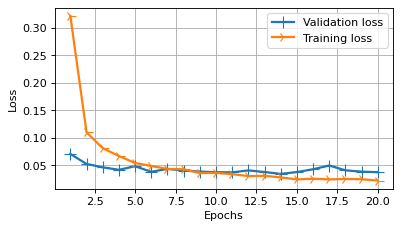

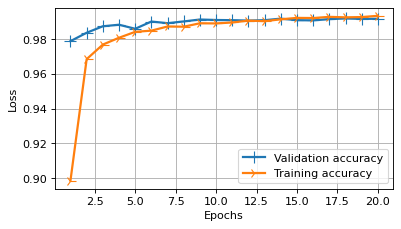

In [24]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 3), dpi=80)

plt.subplot(1,2,1)
line1 = plt.plot(epochs, val_loss_values, label='Validation loss')
line2 = plt.plot(epochs, loss_values, label='Training loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 3), dpi=80)
plt.subplot(1,2,2)
line3 = plt.plot(epochs, val_acc_values, label='Validation accuracy')
line4 = plt.plot(epochs, acc_values, label='Training accuracy')
plt.setp(line3, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line4, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

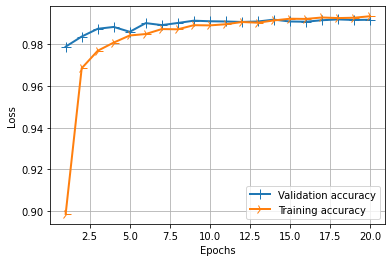

In [25]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation accuracy')
line2 = plt.plot(epochs, acc_values, label='Training accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [26]:
def draw_test(name, pred, input_im):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(input_im, 0, 0, 0, input_im.shape[0], cv2.BORDER_CONSTANT, value=BLACK)
    expanded_image = cv2.cvtColor(expanded_image, cv2.COLOR_GRAY2BGR)
    cv2.putText(expanded_image, str(pred), (152, 70), cv2.FONT_HERSHEY_COMPLEX_SMALL,4,(0,255,0),2)
    cv2.imshow(name, expanded_image)

In [27]:
for i in range(0,10):
    rand = np.random.randint(0,len(x_test))
    input_im = x_test[rand]
    
    imageL = cv2.resize(input_im, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)
    input_im = input_im.reshape(1,28,28,1)
    
    res = str(model.predict_classes(input_im, 1, verbose=0)[0])
    
    draw_test('Prediction', res, imageL)
    cv2.waitKey(0)
    
cv2.destroyAllWindows()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
